# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [3]:
df = pd.read_csv('../../datasets/cleaned_dataset.csv')

df = df[[
         'HDays', 'ADays',
         'HASLxM', 'HASTLxM', 
         'HACLxM', 'HAFLxM', 'HAYCLxM', 'HARCLxM',
         'HAGSLxM', 'HAGCLxM', 'HAGSLxHM', 'HAGCLxHM',
         'HGDLxM', 'HGDLxHM', 'HAPLxM', 'HAPLxHM',
         'HWPLxM', 'HWPLxHM',
         'HWinStreak',
         'AASLxM', 'AASTLxM', 
         'AACLxM', 'AAFLxM', 'AAYCLxM', 'AARCLxM',
         'AAGSLxM', 'AAGCLxM', 'AAGSLxAM', 'AAGCLxAM',
         'AGDLxM', 'AGDLxAM', 'AAPLxM','AAPLxAM',
         'AWPLxM', 'AWPLxAM', 
         'AWinStreak', 
         'HDef', 'HMid', 'HAtt', 'HOvr',
         'ADef', 'AMid', 'AAtt', 'AOvr',
         'B365H', 'B365D', 'B365A',
         'Venue',
         'Result'
        ]]

df = df.dropna(axis=0).reset_index(drop=True)

# 3. Feature Selection

In [4]:
selected_features = ['AAGSLxM', 'AASLxM', 'HOvr', 'AOvr', 'HAGSLxM', 'B365H', 'B365D', 'HASLxM', 'AAGCLxM', 'Venue']

# 4. Model Building- Data Split 5

- Target Variable: Lose/Draw
- Stratified Sampling

In [5]:
# label encode categorical feature- VENUE
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

dict(zip(venue_le.classes_, range(len(venue_le.classes_))))

{'Anfield': 0,
 'Bet365 Stadium': 1,
 'Boleyn Ground': 2,
 'Bramall Lane': 3,
 'Brentford Community Stadium': 4,
 'Cardiff City Stadium': 5,
 'Carrow Road': 6,
 'Craven Cottage': 7,
 'DW Stadium': 8,
 'Dean Court': 9,
 'Elland Road': 10,
 'Emirates Stadium': 11,
 'Etihad Stadium': 12,
 'Falmer Stadium': 13,
 'Goodison Park': 14,
 'Hull City Stadium': 15,
 'King Power Stadium': 16,
 'Kirklees Stadium': 17,
 'Loftus Road': 18,
 'London Stadium': 19,
 'Madejski Stadium': 20,
 'Molineux Stadium': 21,
 'Old Trafford': 22,
 'Riverside Stadium': 23,
 'Selhurst Park': 24,
 "St Mary's Stadium": 25,
 'St. James Park': 26,
 'Stadium of Light': 27,
 'Stamford Bridge': 28,
 'Swansea.com Stadium': 29,
 'The Hawthorns': 30,
 'Tottenham Hotspur Stadium': 31,
 'Turf Moor': 32,
 'Vicarage Road': 33,
 'Villa Park': 34,
 'Wembley Stadium': 35,
 'White Hart Lane': 36}

### Random Forest Classifier

#### Fold 1

In [6]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=500, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1})
y_test = y_test.map({'D': 0, 'L': 1})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    848
0    620
Name: Result, dtype: int64
1    211
0    155
Name: Result, dtype: int64


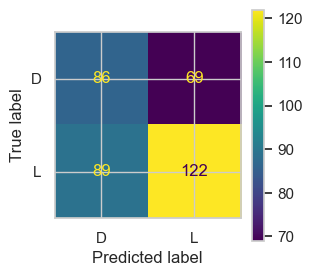

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [8]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5683060109289617
ROC score on Test Set: 0.5883809815012995

              precision    recall  f1-score   support

           0       0.49      0.55      0.52       155
           1       0.64      0.58      0.61       211

    accuracy                           0.57       366
   macro avg       0.57      0.57      0.56       366
weighted avg       0.58      0.57      0.57       366



#### Fold 2

In [9]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=500, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1})
y_test = y_test.map({'D': 0, 'L': 1})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


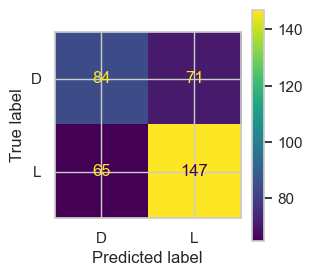

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [11]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6294277929155313
ROC score on Test Set: 0.663572732805843

              precision    recall  f1-score   support

           0       0.56      0.54      0.55       155
           1       0.67      0.69      0.68       212

    accuracy                           0.63       367
   macro avg       0.62      0.62      0.62       367
weighted avg       0.63      0.63      0.63       367



#### Fold 3

In [12]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=500, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1})
y_test = y_test.map({'D': 0, 'L': 1})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


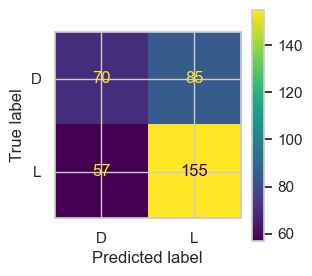

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6130790190735694
ROC score on Test Set: 0.6744674376141205

              precision    recall  f1-score   support

           0       0.55      0.45      0.50       155
           1       0.65      0.73      0.69       212

    accuracy                           0.61       367
   macro avg       0.60      0.59      0.59       367
weighted avg       0.61      0.61      0.61       367



#### Fold 4

In [15]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=500, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1})
y_test = y_test.map({'D': 0, 'L': 1})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


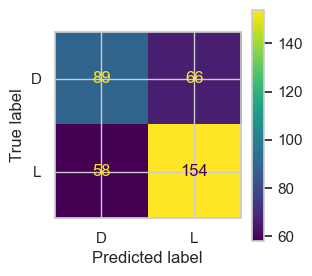

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [17]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.662125340599455
ROC score on Test Set: 0.6917528910529518

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       155
           1       0.70      0.73      0.71       212

    accuracy                           0.66       367
   macro avg       0.65      0.65      0.65       367
weighted avg       0.66      0.66      0.66       367



#### Fold 5

In [18]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=500, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1})
y_test = y_test.map({'D': 0, 'L': 1})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


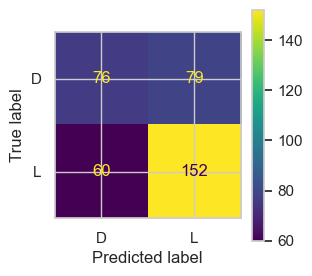

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [20]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6212534059945504
ROC score on Test Set: 0.677145465611686

              precision    recall  f1-score   support

           0       0.56      0.49      0.52       155
           1       0.66      0.72      0.69       212

    accuracy                           0.62       367
   macro avg       0.61      0.60      0.60       367
weighted avg       0.62      0.62      0.62       367



### Logistic Regression

#### Fold 1

In [21]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    848
0    620
Name: Result, dtype: int64
1    211
0    155
Name: Result, dtype: int64


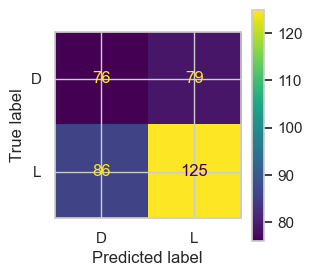

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [23]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5491803278688525
ROC score on Test Set: 0.6051674055954747

              precision    recall  f1-score   support

           0       0.47      0.49      0.48       155
           1       0.61      0.59      0.60       211

    accuracy                           0.55       366
   macro avg       0.54      0.54      0.54       366
weighted avg       0.55      0.55      0.55       366



#### Fold 2

In [24]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


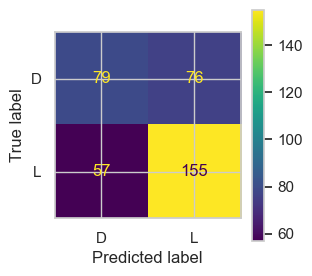

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6376021798365122
ROC score on Test Set: 0.6599817407181984

              precision    recall  f1-score   support

           0       0.58      0.51      0.54       155
           1       0.67      0.73      0.70       212

    accuracy                           0.64       367
   macro avg       0.63      0.62      0.62       367
weighted avg       0.63      0.64      0.63       367



#### Fold 3

In [27]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


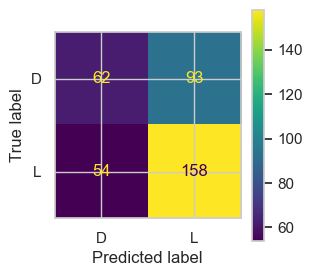

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [29]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5994550408719346
ROC score on Test Set: 0.6717589774802192

              precision    recall  f1-score   support

           0       0.53      0.40      0.46       155
           1       0.63      0.75      0.68       212

    accuracy                           0.60       367
   macro avg       0.58      0.57      0.57       367
weighted avg       0.59      0.60      0.59       367



#### Fold 4

In [30]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


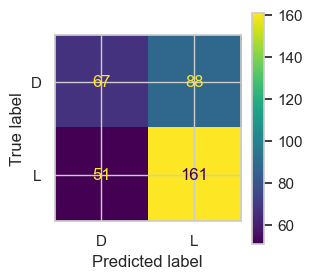

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [32]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6212534059945504
ROC score on Test Set: 0.6746195982958003

              precision    recall  f1-score   support

           0       0.57      0.43      0.49       155
           1       0.65      0.76      0.70       212

    accuracy                           0.62       367
   macro avg       0.61      0.60      0.59       367
weighted avg       0.61      0.62      0.61       367



#### Fold 5

In [33]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


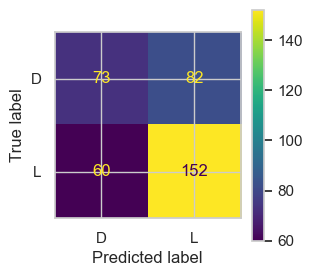

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [35]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6130790190735694
ROC score on Test Set: 0.6655203895313451

              precision    recall  f1-score   support

           0       0.55      0.47      0.51       155
           1       0.65      0.72      0.68       212

    accuracy                           0.61       367
   macro avg       0.60      0.59      0.59       367
weighted avg       0.61      0.61      0.61       367



### SVM Classifier

#### Fold 1

In [36]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    848
0    620
Name: Result, dtype: int64
1    211
0    155
Name: Result, dtype: int64


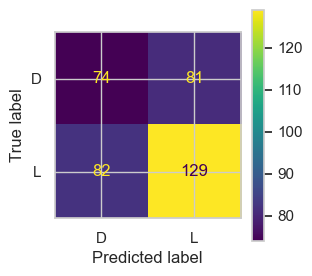

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [38]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5546448087431693
ROC score on Test Set: 0.5857514141568567

              precision    recall  f1-score   support

           0       0.47      0.48      0.48       155
           1       0.61      0.61      0.61       211

    accuracy                           0.55       366
   macro avg       0.54      0.54      0.54       366
weighted avg       0.56      0.55      0.55       366



#### Fold 2

In [39]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


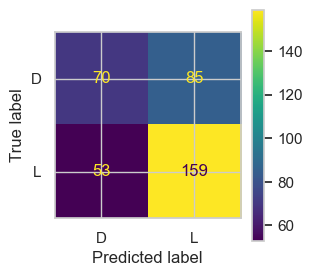

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [41]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6239782016348774
ROC score on Test Set: 0.6403834449178333

              precision    recall  f1-score   support

           0       0.57      0.45      0.50       155
           1       0.65      0.75      0.70       212

    accuracy                           0.62       367
   macro avg       0.61      0.60      0.60       367
weighted avg       0.62      0.62      0.62       367



#### Fold 3

In [42]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


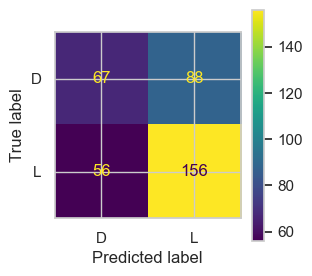

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [44]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6076294277929155
ROC score on Test Set: 0.6596013390139988

              precision    recall  f1-score   support

           0       0.54      0.43      0.48       155
           1       0.64      0.74      0.68       212

    accuracy                           0.61       367
   macro avg       0.59      0.58      0.58       367
weighted avg       0.60      0.61      0.60       367



#### Fold 4

In [45]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


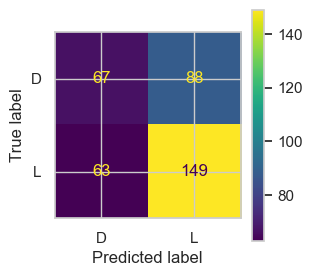

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [47]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5885558583106267
ROC score on Test Set: 0.6519780888618381

              precision    recall  f1-score   support

           0       0.52      0.43      0.47       155
           1       0.63      0.70      0.66       212

    accuracy                           0.59       367
   macro avg       0.57      0.57      0.57       367
weighted avg       0.58      0.59      0.58       367



#### Fold 5

In [48]:
# svm classifier
svc_classifier = SVC(C=100, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


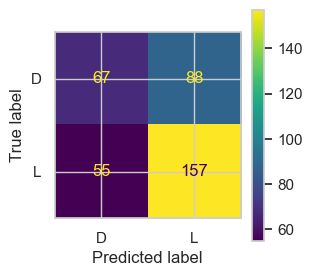

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [50]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6103542234332425
ROC score on Test Set: 0.6565733414485696

              precision    recall  f1-score   support

           0       0.55      0.43      0.48       155
           1       0.64      0.74      0.69       212

    accuracy                           0.61       367
   macro avg       0.59      0.59      0.59       367
weighted avg       0.60      0.61      0.60       367



### XGBoost Classifier

#### Fold 1

In [51]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=3, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    848
0    620
Name: Result, dtype: int64
1    211
0    155
Name: Result, dtype: int64


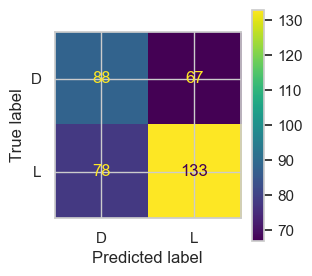

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [53]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6038251366120219
ROC score on Test Set: 0.6036844519186668

              precision    recall  f1-score   support

           0       0.53      0.57      0.55       155
           1       0.67      0.63      0.65       211

    accuracy                           0.60       366
   macro avg       0.60      0.60      0.60       366
weighted avg       0.61      0.60      0.61       366



#### Fold 2

In [54]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=3, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


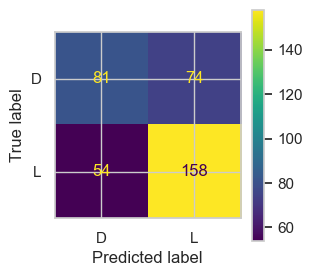

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [56]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6512261580381471
ROC score on Test Set: 0.6546256847230675

              precision    recall  f1-score   support

           0       0.60      0.52      0.56       155
           1       0.68      0.75      0.71       212

    accuracy                           0.65       367
   macro avg       0.64      0.63      0.64       367
weighted avg       0.65      0.65      0.65       367



#### Fold 3

In [57]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=3, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


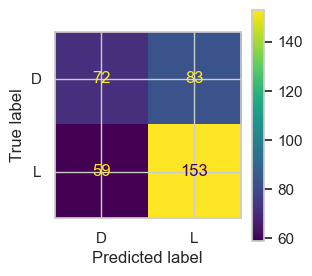

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [59]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6130790190735694
ROC score on Test Set: 0.6591296409007912

              precision    recall  f1-score   support

           0       0.55      0.46      0.50       155
           1       0.65      0.72      0.68       212

    accuracy                           0.61       367
   macro avg       0.60      0.59      0.59       367
weighted avg       0.61      0.61      0.61       367



#### Fold 4

In [60]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=3, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


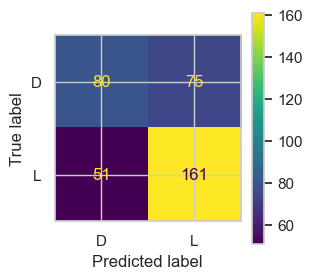

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [62]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6566757493188011
ROC score on Test Set: 0.6776932440657334

              precision    recall  f1-score   support

           0       0.61      0.52      0.56       155
           1       0.68      0.76      0.72       212

    accuracy                           0.66       367
   macro avg       0.65      0.64      0.64       367
weighted avg       0.65      0.66      0.65       367



#### Fold 5

In [63]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=3, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    847
0    620
Name: Result, dtype: int64
1    212
0    155
Name: Result, dtype: int64


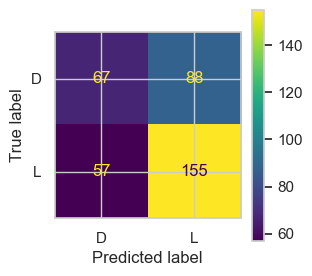

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L'])
cmp.plot(ax=ax)

plt.show()

In [65]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6049046321525886
ROC score on Test Set: 0.655203895313451

              precision    recall  f1-score   support

           0       0.54      0.43      0.48       155
           1       0.64      0.73      0.68       212

    accuracy                           0.60       367
   macro avg       0.59      0.58      0.58       367
weighted avg       0.60      0.60      0.60       367

